ML-only CV: [0.91925466 0.86956522 0.88198758 0.91304348 0.89375   ] mean: 0.8955201863354038
Hybrid CV: [0.91304348 0.85714286 0.91304348 0.95031056 0.9       ] mean: 0.9067080745341615

--- ML-only Report ---
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       129
           1       0.82      0.82      0.82        73

    accuracy                           0.87       202
   macro avg       0.86      0.86      0.86       202
weighted avg       0.87      0.87      0.87       202


--- Hybrid Report ---
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       129
           1       0.81      0.84      0.82        73

    accuracy                           0.87       202
   macro avg       0.86      0.86      0.86       202
weighted avg       0.87      0.87      0.87       202



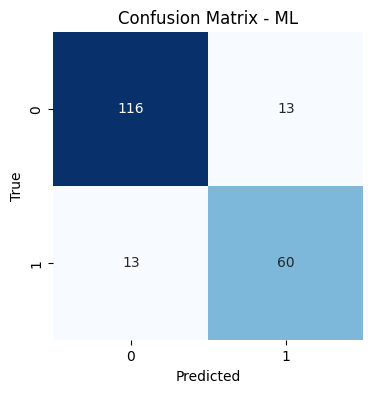

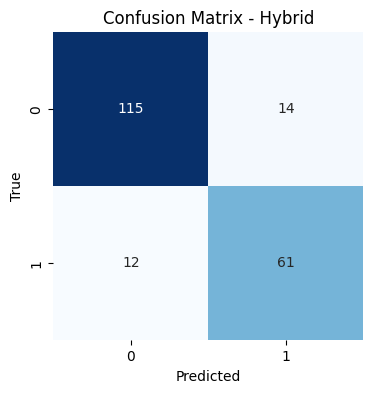

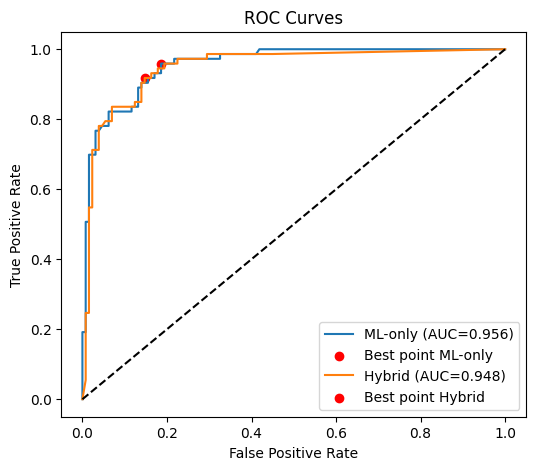

Results saved: results.csv & summary.csv
✅ Models saved: rf_ml_only.pkl & rf_hybrid.pkl (with feature names)


In [7]:
# rf_hybrid_vs_ml_with_features.py
"""
Random Forest vs Hybrid Random Forest (Rule + ML) comparison.
- Cleans column names & numeric values
- Detects target column
- Runs Random Forest with and without Hybrid corrections
- Logs predictions into results.csv
- Saves summary metrics into summary.csv
- Plots ROC curve (with best threshold point) & confusion matrices
- Saves trained ML-only and Hybrid models separately, including feature names
"""

import re, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    accuracy_score
)
from sklearn.ensemble import RandomForestClassifier

warnings.filterwarnings("ignore")

# -------------------------
# Helpers
# -------------------------
def sanitize_colname(s):
    return re.sub(r'[^A-Za-z0-9_]+', '', str(s).strip())

def clean_numeric_series(s: pd.Series) -> pd.Series:
    s = s.astype(str).fillna("")
    s = s.str.replace(r'[\u2010\u2011\u2012\u2013\u2014\u2212–—−]', '-', regex=True)
    s = s.str.replace(r'[,\~±]', '', regex=True)
    num = s.str.extract(r'(-?\d+\.?\d*(?:[eE][+-]?\d+)?)', expand=False)
    return pd.to_numeric(num, errors='coerce')

def make_onehot():
    try:
        return OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown='ignore', sparse=False)

def get_probs_from_pipeline(pipe: Pipeline, X):
    clf = pipe.named_steps.get('classifier', pipe.steps[-1][1])
    if hasattr(clf, 'predict_proba'):
        return pipe.predict_proba(X)[:, 1]
    if hasattr(clf, 'decision_function'):
        scores = pipe.decision_function(X)
        if np.ptp(scores) == 0:
            return np.zeros_like(scores, dtype=float)
        return (scores - scores.min()) / (scores.max() - scores.min())
    return np.zeros(len(X), dtype=float)

# -------------------------
# Load dataset
# -------------------------
df = pd.read_excel("Dataset.xlsx")
col_map = {c: sanitize_colname(c) for c in df.columns}
df = df.rename(columns=col_map)

# detect target column
target_col = None
for c in df.columns:
    if "angiogen" in c.lower():
        target_col = c
        break
if target_col is None:
    raise KeyError("Target column not found (needs 'angiogen' in header).")

# separate target
y = pd.to_numeric(df[target_col], errors="coerce").astype(int)
df = df.drop(columns=[target_col])  # drop target from features

# drop phytochemical names
phyt_candidates = [c for c in df.columns if any(k in c.lower() for k in ["phytochem","compound","name"])]
df = df.drop(columns=phyt_candidates, errors="ignore")

# detect docking/admet
docking_col, admet_col = None, None
for c in df.columns:
    cl = c.lower()
    if docking_col is None and ("dock" in cl or "score" in cl):
        docking_col = c
    if admet_col is None and "admet" in cl:
        admet_col = c

# numeric vs categorical
numeric_cols, categorical_features = [], []
for c in df.columns:
    cleaned = clean_numeric_series(df[c])
    if cleaned.notna().mean() >= 0.3:
        df[c] = cleaned
        numeric_cols.append(c)
    elif df[c].dtype == object:
        categorical_features.append(c)

# enforce docking/admet numeric
if docking_col:
    df[docking_col] = clean_numeric_series(df[docking_col])
    if docking_col not in numeric_cols:
        numeric_cols.append(docking_col)
if admet_col:
    df[admet_col] = pd.to_numeric(df[admet_col], errors="coerce")
    if admet_col not in numeric_cols:
        numeric_cols.append(admet_col)

X = df.copy()

# -------------------------
# Preprocessor
# -------------------------
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", make_onehot())
])
preprocessor = ColumnTransformer(
    [("num", num_pipe, numeric_cols), ("cat", cat_pipe, categorical_features)],
    remainder="drop"
)

# -------------------------
# Rules
# -------------------------
def rule_based_decision_row(row):
    dock = float(row[docking_col]) if docking_col and pd.notnull(row.get(docking_col)) else None
    admet = int(row[admet_col]) if admet_col and pd.notnull(row.get(admet_col)) else None
    if admet == 0:
        return 0
    if dock is not None and admet == 1 and dock <= -9.0:
        return 1
    return None

def apply_hybrid_rules(Xdf, ml_preds, ml_probs):
    rd = Xdf.apply(rule_based_decision_row, axis=1)
    preds, probs = ml_preds.copy(), ml_probs.copy().astype(float)
    for i, decision in enumerate(rd):
        if decision in (0,1):
            preds[i] = decision
            probs[i] = 1.0 if decision == 1 else 0.0
    return preds, probs

# -------------------------
# Train/test split
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# -------------------------
# Random Forest model
# -------------------------
rf = RandomForestClassifier(n_estimators=300, random_state=42)
pipeline = Pipeline([("preprocessor", preprocessor), ("classifier", rf)])

# CV accuracies
ml_cv = cross_val_score(pipeline, X_train, y_train, cv=5, scoring="accuracy")
print("ML-only CV:", ml_cv, "mean:", ml_cv.mean())

# Hybrid CV (manual)
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

hybrid_cv = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for tr, val in cv.split(X_train, y_train):
    pipeline.fit(X_train.iloc[tr], y_train.iloc[tr])
    ml_preds = pipeline.predict(X_train.iloc[val])
    ml_probs = get_probs_from_pipeline(pipeline, X_train.iloc[val])
    hy_preds, _ = apply_hybrid_rules(X_train.iloc[val], ml_preds, ml_probs)
    hybrid_cv.append(accuracy_score(y_train.iloc[val], hy_preds))
hybrid_cv = np.array(hybrid_cv)
print("Hybrid CV:", hybrid_cv, "mean:", hybrid_cv.mean())

# -------------------------
# Test evaluation
# -------------------------
pipeline.fit(X_train, y_train)
ml_preds_test = pipeline.predict(X_test)
ml_probs_test = get_probs_from_pipeline(pipeline, X_test)
hy_preds_test, hy_probs_test = apply_hybrid_rules(X_test, ml_preds_test, ml_probs_test)

print("\n--- ML-only Report ---")
print(classification_report(y_test, ml_preds_test))
print("\n--- Hybrid Report ---")
print(classification_report(y_test, hy_preds_test))

# -------------------------
# Confusion Matrices
# -------------------------
def plot_cm(y_true, preds, title):
    cm = confusion_matrix(y_true, preds)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

plot_cm(y_test, ml_preds_test, "Confusion Matrix - ML")
plot_cm(y_test, hy_preds_test, "Confusion Matrix - Hybrid")

# -------------------------
# ROC curve with best threshold
# -------------------------
def plot_roc(y_true, probs, label):
    fpr, tpr, thresholds = roc_curve(y_true, probs)
    auc = roc_auc_score(y_true, probs)
    J = tpr - fpr
    ix = np.argmax(J)
    plt.plot(fpr, tpr, label=f"{label} (AUC={auc:.3f})")
    plt.scatter(fpr[ix], tpr[ix], marker="o", color="red", label=f"Best point {label}")
    return auc

plt.figure(figsize=(6,5))
auc_ml = plot_roc(y_test, ml_probs_test, "ML-only")
auc_hy = plot_roc(y_test, hy_probs_test, "Hybrid")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()

# -------------------------
# Save logs
# -------------------------
results_log = X_test.copy()
results_log["TrueLabel"] = y_test
results_log["ML_Pred"] = ml_preds_test
results_log["Hybrid_Pred"] = hy_preds_test
results_log.to_csv("results.csv", index=False)

summary = pd.DataFrame([{
    "Model": "Random Forest",
    "ML_CV_mean": ml_cv.mean(),
    "Hybrid_CV_mean": hybrid_cv.mean(),
    "Test_Acc_ML": accuracy_score(y_test, ml_preds_test),
    "Test_Acc_Hybrid": accuracy_score(y_test, hy_preds_test),
    "ROC_AUC_ML": auc_ml,
    "ROC_AUC_Hybrid": auc_hy
}])
summary.to_csv("summary.csv", index=False)
print("Results saved: results.csv & summary.csv")

# -------------------------
# -------------------------
# Save trained models with feature names
# -------------------------

# Bundle ML-only pipeline with its features
ml_model_bundle = {
    "model": pipeline,
    "numeric_cols": numeric_cols,
    "categorical_features": categorical_features,
}
joblib.dump(ml_model_bundle, "rf_ml_only.pkl")

# Bundle Hybrid pipeline with rules + features
hybrid_bundle = {
    "model": pipeline,
    "docking_col": docking_col,
    "admet_col": admet_col,
    "numeric_cols": numeric_cols,
    "categorical_features": categorical_features,
}
joblib.dump(hybrid_bundle, "rf_hybrid.pkl")

print("✅ Models saved: rf_ml_only.pkl & rf_hybrid.pkl (with feature names)")



In [24]:
import joblib

# Load your original model bundles
rf_ml_only_bundle = joblib.load("rf_ml_only.pkl")
rf_hybrid_bundle = joblib.load("rf_hybrid.pkl")

# Function to clean a bundle
def clean_bundle(bundle, target_col='VEGFR-2'):
    # Remove Plant Source and target from features
    bundle['numeric_cols'] = [f for f in bundle['numeric_cols'] if f not in ['Plant Source', target_col]]
    bundle['categorical_features'] = [f for f in bundle['categorical_features'] if f not in ['Plant Source', target_col]]
    # Ensure target key exists for autofill
    bundle['target'] = target_col
    return bundle

# Clean both bundles
rf_ml_only_bundle_clean = clean_bundle(rf_ml_only_bundle)
rf_hybrid_bundle_clean = clean_bundle(rf_hybrid_bundle)

# Save cleaned bundles
joblib.dump(rf_ml_only_bundle_clean, "rf_ml_only_cleaned.pkl")
joblib.dump(rf_hybrid_bundle_clean, "rf_hybrid_cleaned.pkl")

print("Cleaned bundles saved successfully!")


Cleaned bundles saved successfully!


In [37]:
import tkinter as tk
from tkinter import ttk, messagebox
import pandas as pd
import joblib

# -------------------------------
# Load cleaned models
# -------------------------------
rf_ml_only_bundle = joblib.load("rf_ml_only_cleaned.pkl")
rf_hybrid_bundle = joblib.load("rf_hybrid_cleaned.pkl")

models = {
    "RF ML Only": rf_ml_only_bundle,
    "RF Hybrid": rf_hybrid_bundle
}

# -------------------------------
# Load dataset to populate PlantSource dropdown
# -------------------------------
df = pd.read_excel("Dataset.xlsx")

# Sanitize column names (remove spaces)
df.columns = [c.strip().replace(" ", "") for c in df.columns]

# PlantSource dropdown
if "PlantSource" not in df.columns:
    raise KeyError("Column 'Plant Source' not found in dataset. Check your Excel file.")

plant_source_list = df['PlantSource'].dropna().unique().tolist()

# -------------------------------
# GUI Setup
# -------------------------------
root = tk.Tk()
root.title("Prediction GUI")

# PlantSource dropdown
tk.Label(root, text="PlantSource:").grid(row=0, column=0, sticky='w')
plant_var = tk.StringVar()
plant_dropdown = ttk.Combobox(root, textvariable=plant_var, values=plant_source_list, state="readonly")
plant_dropdown.grid(row=0, column=1)
plant_dropdown.current(0)  # autofill with first plant source

# -------------------------------
# Input fields for numeric/categorical features
# -------------------------------
feature_list = [
    'DockingScorekcalmol', 'ADMETHighlights1ADMETpasses0ADMETnotpasses',
    'MWgmol', 'LogP', 'TPSA', 'HBD', 'HBA', 'RotB', 'AromaticRings', 'MR'
]

entry_vars = {}
row_index = 1
for feature in feature_list:
    tk.Label(root, text=feature + ":").grid(row=row_index, column=0, sticky='w')
    var = tk.StringVar()
    tk.Entry(root, textvariable=var).grid(row=row_index, column=1)
    entry_vars[feature] = var
    row_index += 1

# -------------------------------
# Table to show predictions
# -------------------------------
result_frame = tk.Frame(root)
result_frame.grid(row=row_index, column=0, columnspan=2, pady=10)

ttk.Label(result_frame, text="Model").grid(row=0, column=0, padx=10)
ttk.Label(result_frame, text="Prediction Probability").grid(row=0, column=1, padx=10)

result_labels = {}
for i, model_name in enumerate(models.keys(), start=1):
    ttk.Label(result_frame, text=model_name).grid(row=i, column=0, padx=10)
    lbl = ttk.Label(result_frame, text="")
    lbl.grid(row=i, column=1, padx=10)
    result_labels[model_name] = lbl

# -------------------------------
# Prediction function
# -------------------------------
def predict():
    try:
        input_data = {}

        # Numeric/categorical features from manual input
        for feature in feature_list:
            value = entry_vars[feature].get()
            if value.strip() == "":
                raise ValueError(f"{feature} cannot be empty.")
            input_data[feature] = [float(value)]

        # PlantSource from dropdown
        input_data['PlantSource'] = [plant_var.get()]

        # Autofill Target
        input_data['Target'] = [-2]

        df_input = pd.DataFrame(input_data)

        # Predict with both models
        for model_name, bundle in models.items():
            model = bundle['model']
            if hasattr(model, "predict_proba"):
                prob = model.predict_proba(df_input)[0][1]
                result_labels[model_name].config(text=f"{prob:.4f}")
            else:
                pred = model.predict(df_input)[0]
                result_labels[model_name].config(text=str(pred))

    except Exception as e:
        for lbl in result_labels.values():
            lbl.config(text="Error")
        tk.messagebox.showerror("Error", str(e))

# Predict button
tk.Button(root, text="Predict", command=predict).grid(row=row_index+1, column=0, columnspan=2, pady=10)

root.mainloop()
